<h1> Wireline Log Analysis </h1> 

<h2> Part 1 </h2>
<h3> Clustering on Triple Combo Logs </h3>

We are going to do clustering on triple combo logs and compare the results with geologist's analysis

In [290]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import Adam, RMSprop
# from keras.models import Model
# from keras import Input
# from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [64]:
def load_LAS(filename):
    '''
    Load LAS file
    Args:
        filename: LAS file to load
    Return:
        las_df: LAS file in dataframe format
    '''
    
    #load the data
    las = lasio.read(filename)

    #convert to dataframe
    las_df = las.df()
    las_df = las_df.replace(-999.25, np.nan)

    #create a new column called 'DEPTH'
    las_df['DEPTH']=las_df.index
    return las_df


las_df_well_1 = load_LAS("./data/well_1.las")
las_df_well_1

Header section Parameter regexp=~P was not found.


,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,,,,
1400.0988,NaN,78.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6060,1.6745,400943.1563,87039.0547,1399.7334,1400.0988
1400.2512,NaN,77.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6067,1.6753,400943.1563,87039.0469,1399.8857,1400.2512
1400.4036,NaN,76.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6074,1.6760,400943.1563,87039.0469,1400.0381,1400.4036
1400.5560,NaN,75.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6080,1.6768,400943.1563,87039.0391,1400.1904,1400.5560
1400.7084,NaN,72.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.6087,1.6775,400943.1563,87039.0391,1400.3428,1400.7084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757.7816,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.3054,1757.7816
1757.9340,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.4578,1757.9340
1758.0864,NaN,77.81,NaN,NaN,NaN,NaN,0.2385,2.621,2.4,2.66,135.75,17.563,3.85,148.0049,0.2704,400946.0625,87032.6563,1757.6101,1758.0864


In [65]:
#select only depths that have complete curves
las_df_well_1 = las_df_well_1.dropna()
las_df_well_1

,CALI,DTC,GR,LLD,LLS,MSFL,NPHI,PEF,POTA,RHOB,SGR,THOR,URAN,AZIMUTH,INC,EASTING,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,,,,
1487.7288,12.4378,76.81,119.3730,5.0465,4.6057,4.2766,0.3733,3.3767,3.4000,2.53,125.869,10.3179,4.1150,159.9219,2.2297,400944.1875,87036.5000,1487.3195,1487.7288
1487.8812,12.4228,76.69,118.9050,4.7519,4.4229,3.6847,0.3619,3.3475,3.4000,2.54,128.924,10.5556,4.2309,159.9514,2.2370,400944.1875,87036.4922,1487.4718,1487.8812
1488.0336,12.4752,78.75,115.5210,4.4015,4.1144,4.8480,0.3636,3.2653,3.4045,2.54,126.191,10.2088,4.1058,159.9810,2.2444,400944.1875,87036.4922,1487.6240,1488.0336
1488.1860,12.3841,79.88,113.4710,4.2874,4.0418,4.7533,0.3513,3.2798,3.7958,2.53,133.917,10.2958,4.2836,160.0106,2.2518,400944.1875,87036.4844,1487.7764,1488.1860
1488.3384,12.3665,81.06,119.3750,4.0245,3.8622,3.3685,0.3460,3.3632,3.8998,2.53,136.002,10.2981,4.3744,160.0401,2.2592,400944.1875,87036.4766,1487.9286,1488.3384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740.8652,8.5168,83.00,106.5310,3.5122,3.4866,4.2308,0.2812,3.5513,3.0000,2.61,132.765,14.3849,3.8187,148.0049,0.2704,400946.0313,87032.7266,1740.3892,1740.8652
1741.0176,8.5268,82.00,106.8210,3.5838,3.5709,4.2920,0.2799,3.5422,3.0000,2.61,133.229,14.4892,3.7822,148.0049,0.2704,400946.0313,87032.7266,1740.5415,1741.0176
1741.1700,8.2754,81.00,103.8810,3.5194,3.5287,2.8878,0.2624,3.4832,3.0031,2.60,132.471,14.4279,3.6991,148.0049,0.2704,400946.0313,87032.7266,1740.6940,1741.1700


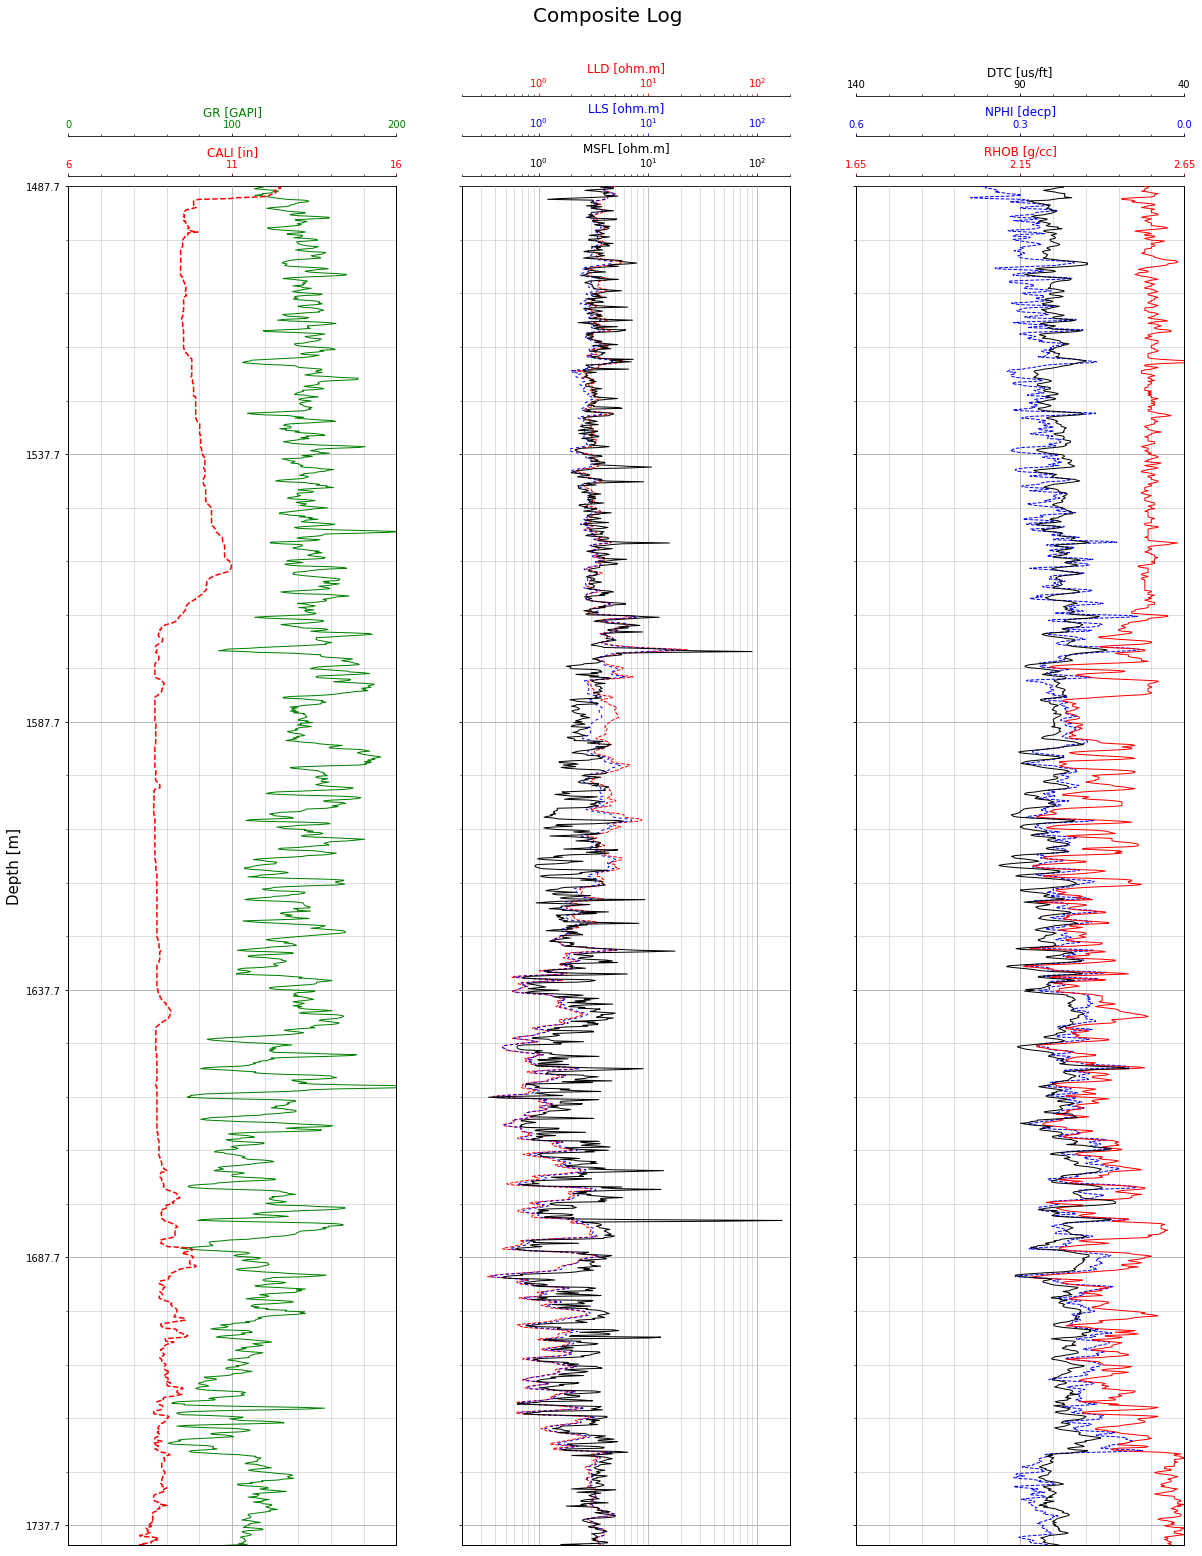

In [189]:
#visualize the log

def wireline_log_plotting(top,bottom,las):
    '''
    Plot wireline log
    
    Args:
        top: the top depth of the log
        bottom: the bottom depth of the log
        las: LASFile to plot
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,25),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.88)

    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)


    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(las['GR'],las['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)

    #CALI
    ax_CALI=ax[0].twiny()
    ax_CALI.set_xlim(6,16)
    ax_CALI.set_xlabel('CALI [in]',color="Red",fontsize=12)
    ax_CALI.plot(las['CALI'],las['DEPTH'],'--',color="Red",label='CALI [in]')
    ax_CALI.tick_params(axis='x', colors='Red')
    ax_CALI.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(6, 17, 5)
    minor_ticks = np.arange(6, 17, 1)
    ax_CALI.set_xticks(major_ticks)
    ax_CALI.set_xticks(minor_ticks, minor=True)


#     #SGR
#     ax_SGR=ax[0].twiny()
#     ax_SGR.set_xlim(0,200)
#     ax_SGR.set_xlabel('SGR [GAPI]',color="Blue",fontsize=12)
#     ax_SGR.plot(las['SGR'],las['DEPTH'],color="Blue",label='SGR [GAPI]',linewidth=1)
#     ax_SGR.tick_params(axis='x', colors='Blue')
#     ax_SGR.spines['top'].set_position(('outward',90))
#     major_ticks = np.arange(0, 201, 100)
#     minor_ticks = np.arange(0, 201, 20)
#     ax_SGR.set_xticks(major_ticks)
#     ax_SGR.set_xticks(minor_ticks, minor=True)


    #Track 2: Resistivity

    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(las['LLD'],las['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #LLS
    ax_LLS=ax[1].twiny()
    ax_LLS.set_xscale('log')
    ax_LLS.set_xlim(0.2,200)
    ax_LLS.set_xlabel('LLS [ohm.m]',color="Blue",fontsize=12)
    ax_LLS.plot(las['LLS'],las['DEPTH'],'--',color="Blue",label='LLS [ohm.m]',dashes=[3,3],linewidth=1)
    ax_LLS.tick_params(axis='x', colors='Blue')
    ax_LLS.spines['top'].set_position(('outward',50))

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(las['MSFL'],las['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(las['NPHI'],las['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(las['RHOB'],las['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(las['DTC'],las['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #PEF
#     ax_PEF=ax[2].twiny()
#     ax_PEF.set_xlim(0,20)
#     ax_PEF.set_xlabel('PEF []',color="Green",fontsize=12)
#     ax_PEF.plot(las['PEF'],las['DEPTH'],color="Green",label='PEF')
#     ax_PEF.tick_params(axis='x', colors='Green')
#     ax_PEF.spines['top'].set_position(('outward',140))
#     major_ticks = np.arange(0, 20, 10)
#     minor_ticks = np.arange(0, 20, 2)
#     ax_PEF.set_xticks(major_ticks)
#     ax_PEF.set_xticks(minor_ticks, minor=True);
    fig.savefig("wireline_log.jpg")

top = las_df_well_1['DEPTH'].min()
bottom = las_df_well_1['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_1)

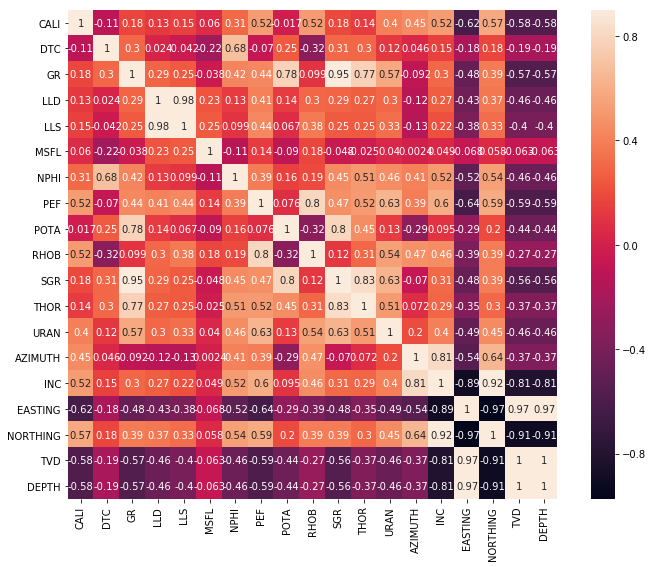

In [67]:
def plot_heatmap(las):
    '''
    Plot heatmap between features
    '''
    corr_matrix = las.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

plot_heatmap(las_df_well_1)

From the correlation map we can see high correlated features: <br>
<b> LLD and LLS </b>: both tell resisitivity <br>
<b> RHOB and PEF </b>: both indicate lithology <br>
<b> GR and SGR </b>: both tell Gamma Ray <br>
We choose LLD, RHOB, and GR <br>
We also remove directional parameters: AZIMUTH, INC, EASTING, NORTHING, TVD <br>
We also remove spectral Gamma Ray parameters: POTA, URAN, THOR <br>

In [113]:
#for our analysis we will only select Triple Combo Curves

def get_triple_combo(df):
    '''
    Get only Triple Combo curves
    '''
    out = df[['DEPTH','GR','NPHI','RHOB','DTC','LLD','MSFL']]
    out.index = pd.RangeIndex(len(out.index))
    return out

las_df_well_1_TC = get_triple_combo(las_df_well_1)
las_df_well_1_TC.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL
0,1487.7288,119.373,0.3733,2.53,76.81,5.0465,4.2766
1,1487.8812,118.905,0.3619,2.54,76.69,4.7519,3.6847
2,1488.0336,115.521,0.3636,2.54,78.75,4.4015,4.8480
3,1488.1860,113.471,0.3513,2.53,79.88,4.2874,4.7533
4,1488.3384,119.375,0.3460,2.53,81.06,4.0245,3.3685


For analysis, we are going to have separated dataframe that contains the scaled parameters

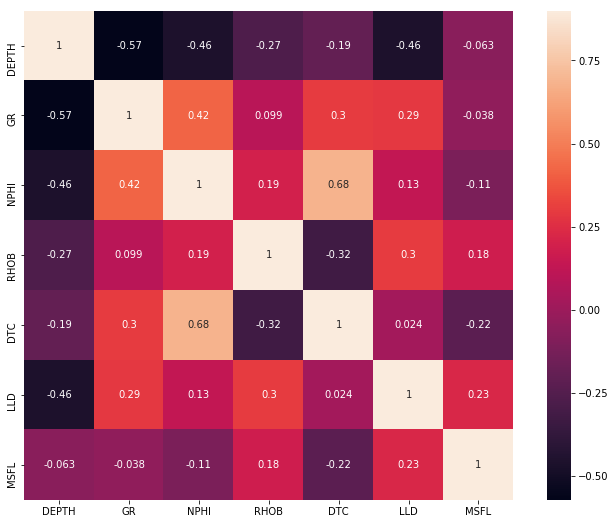

In [81]:
def plot_heatmap(las):
    '''
    Plot heatmap between features
    '''
    corr_matrix = las.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

plot_heatmap(las_df_well_1_TC)

In [114]:
def scaling_features(df_in):
    '''
    scale the features between 0 to 1
    Args:
        df_in: input dataframe to be scaled
    Returns:
        df_scaled: the new scaled dataframe
    '''

    scaler = MinMaxScaler()
    df_temp = df_in
    df_scaled = pd.DataFrame(scaler.fit_transform(df_in), columns=df_in.columns)
    df_scaled['DEPTH'] = df_temp['DEPTH']
    return df_scaled

df_scaled_well_1 = scaling_features(las_df_well_1_TC)
df_scaled_well_1.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.023360
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.019840
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.026759
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.026195
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.017959


First, we are going to do clustering with Triple Combo curves.

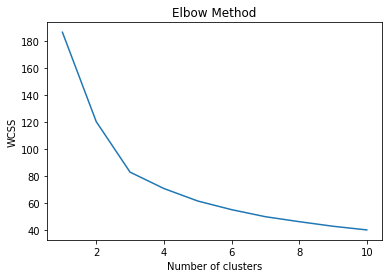

In [88]:
#find the optimum number of clusters using WCSS Elbow Method
#we remove depth from clustering

def find_K(df):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df.drop(['DEPTH'],axis=1))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
find_K(df_scaled_well_1)

We will take K=3 based on above figure

In [115]:
def clustering(df,n_clusters):
    #run the K-means clustering

    kmeans = KMeans(n_clusters=n_clusters)
    k_means = kmeans.fit(df.drop(['DEPTH'],axis=1))
    labels = k_means.labels_

    #save the clustering results in the new column
    df['cluster']=k_means.labels_

clustering(df_scaled_well_1,n_clusters=3)
df_scaled_well_1.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.023360,0
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.019840,0
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.026759,0
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.026195,0
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.017959,0


Now, we want to load facies classified by geologist

In [61]:
#load the facies data from geologist
df_facies = pd.read_csv('./data/facies.csv')
df_facies.head()

,Top Depth (mBRT),Bottom Depth (mBRT),Facies
0,1565.0,1577.5,2
1,1577.5,1580.0,1
2,1580.0,1584.0,2
3,1584.0,1591.0,3
4,1591.0,1596.0,1


In [116]:
#Add cluster column to the unscaled dataframe
las_df_well_1_TC['cluster'] = df_scaled_well_1['cluster']
las_df_well_1_TC.head()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster
0,1487.7288,119.373,0.3733,2.53,76.81,5.0465,4.2766,0
1,1487.8812,118.905,0.3619,2.54,76.69,4.7519,3.6847,0
2,1488.0336,115.521,0.3636,2.54,78.75,4.4015,4.8480,0
3,1488.1860,113.471,0.3513,2.53,79.88,4.2874,4.7533,0
4,1488.3384,119.375,0.3460,2.53,81.06,4.0245,3.3685,0


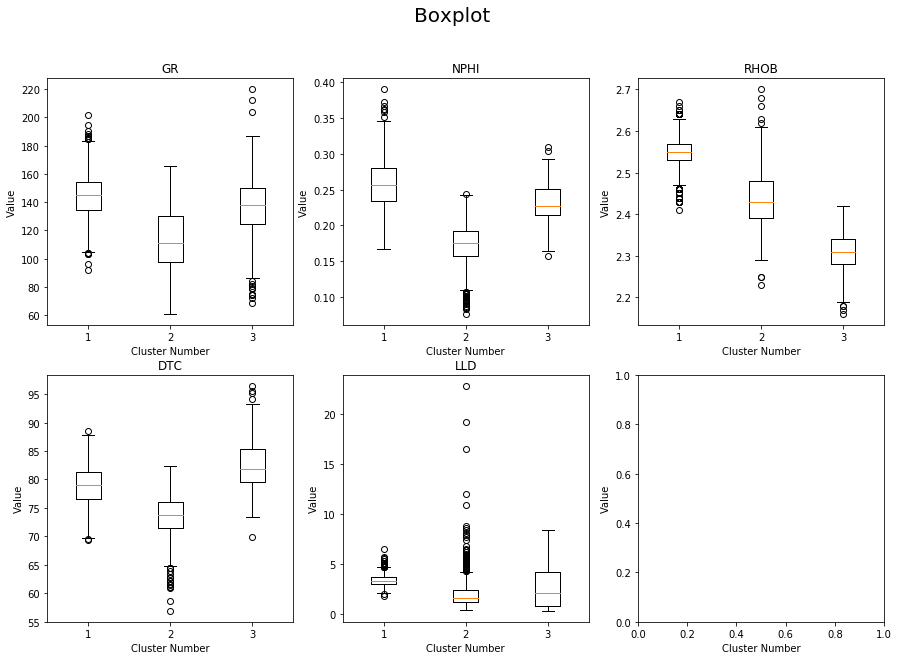

In [117]:
def cluster_boxplot(df,n_clusters):
    #boxplot of each cluster

    ncols=3
    nrows=2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig.suptitle("Boxplot", fontsize=20)
    # fig.subplots_adjust(top=0.88)

    for axis in ax.flat:
        axis.set(xlabel='Cluster Number', ylabel="Value")

    data_to_plot_1=[]
    data_to_plot_2=[]
    data_to_plot_3=[]
    data_to_plot_4=[]
    data_to_plot_5=[]


    for i in range(n_clusters):
        data_to_plot_1.append(df['GR'].loc[df['cluster']==i])
        data_to_plot_2.append(df['NPHI'].loc[df['cluster']==i])
        data_to_plot_3.append(df['RHOB'].loc[df['cluster']==i])
        data_to_plot_4.append(df['DTC'].loc[df['cluster']==i])
        data_to_plot_5.append(df['LLD'].loc[df['cluster']==i])


    # Create the boxplot
    ax[0][0].boxplot(data_to_plot_1)
    ax[0][0].set_title("GR")

    ax[0][1].boxplot(data_to_plot_2)
    ax[0][1].set_title("NPHI")

    ax[0][2].boxplot(data_to_plot_3)
    ax[0][2].set_title("RHOB")

    ax[1][0].boxplot(data_to_plot_4)
    ax[1][0].set_title("DTC")

    ax[1][1].boxplot(data_to_plot_5)
    ax[1][1].set_title("LLD");

cluster_boxplot(las_df_well_1_TC,3)

Let's compare clustering results with facies identified by geologist

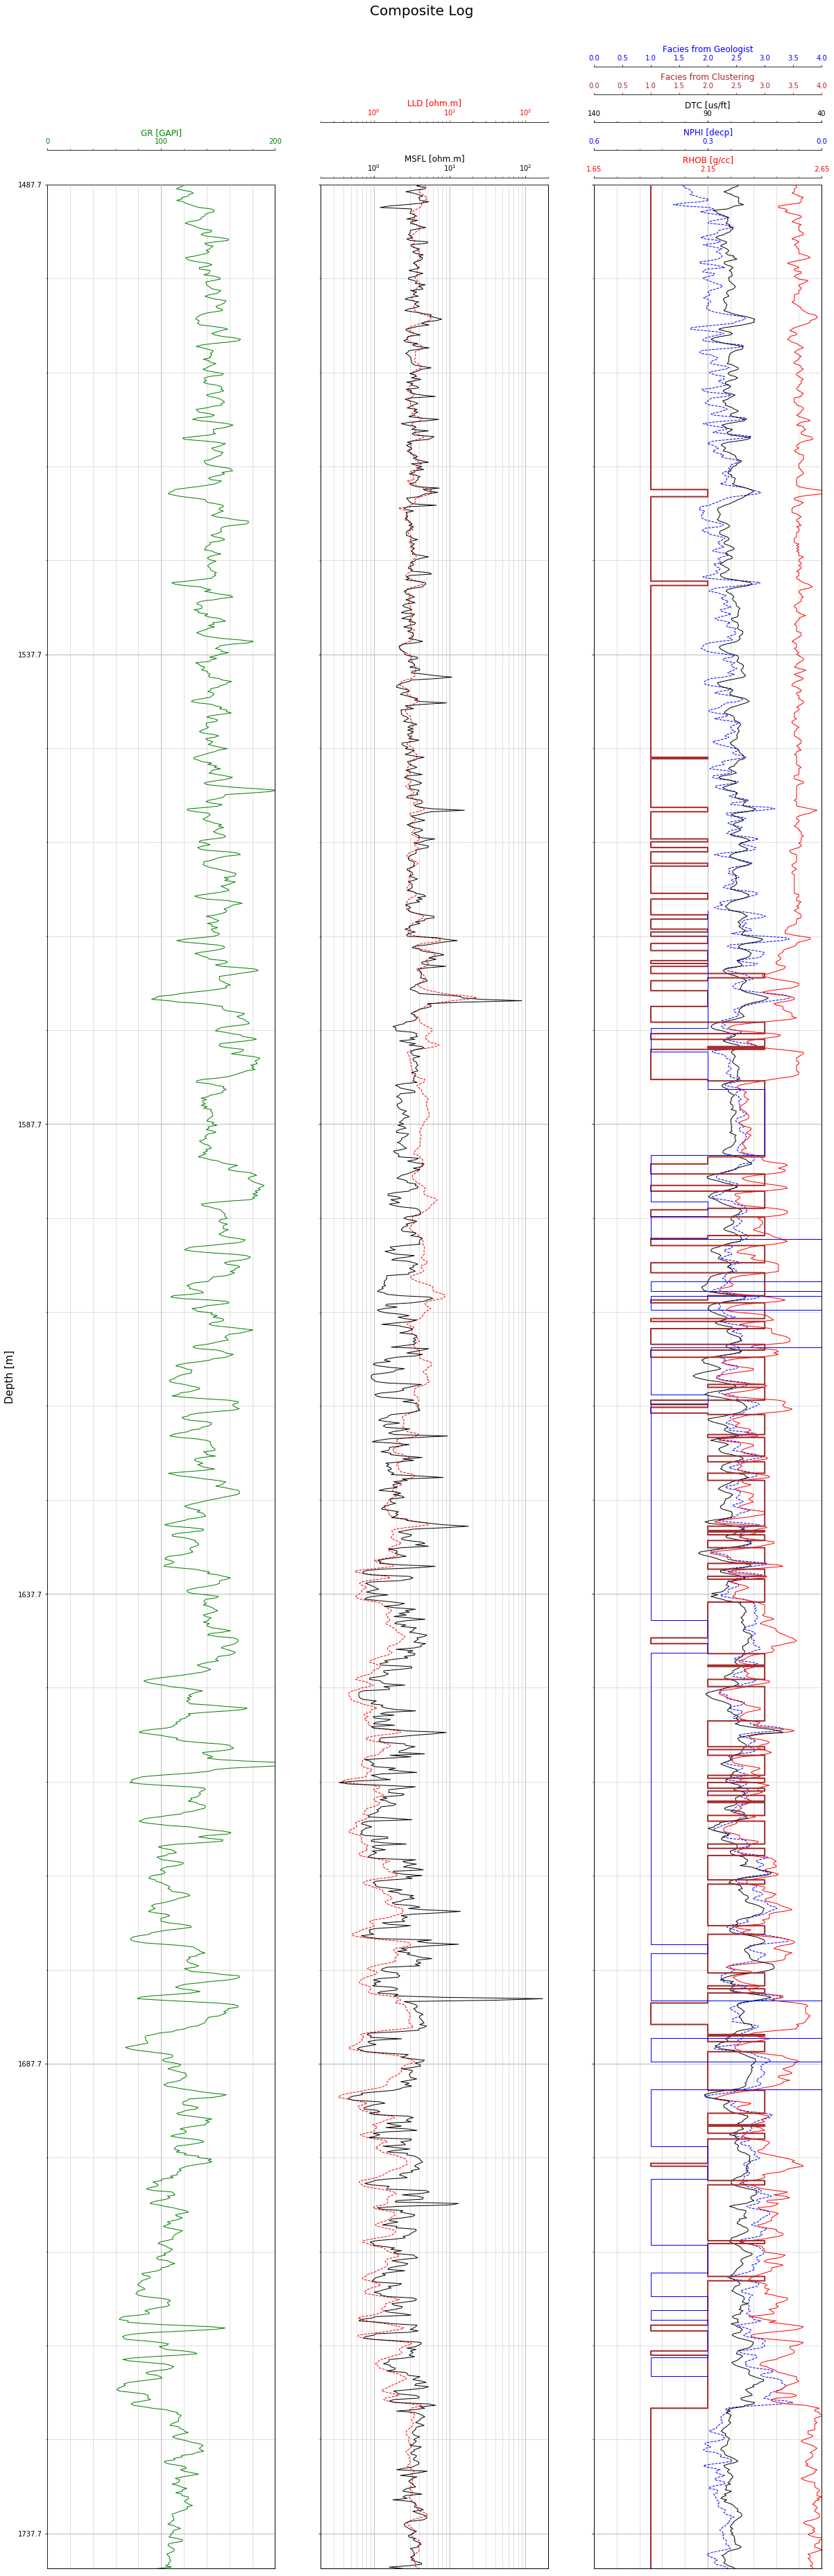

In [123]:
def plot_facies(df,df_facies):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()
    
    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

    #MSFL
    ax_MSFL=ax[1].twiny()
    ax_MSFL.set_xscale('log')
    ax_MSFL.set_xlim(0.2,200)
    ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
    ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
    ax_MSFL.spines['top'].set_position(('outward',10))

    
    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #FACIES FROM CLUSTERING
    ax_fc=ax[2].twiny()
    ax_fc.set_xlim(0,4)
    ax_fc.set_xlabel('Facies from Clustering',color="Brown",fontsize=12)
    ax_fc.step(df['cluster']+1,df['DEPTH'],color="Brown",label='Cluster',linewidth=2)
    ax_fc.tick_params(axis='x', colors='Brown')
    ax_fc.spines['top'].set_position(('outward',130))

    #FACIES FROM GEOLOGIST
    ax_fc2=ax[2].twiny()
    ax_fc2.set_xlim(0,4)
    ax_fc2.set_xlabel('Facies from Geologist',color="Blue",fontsize=12)
    ax_fc2.step(df_facies['Facies'],df_facies['Top Depth (mBRT)'],color="Blue",label='Facies',linewidth=1)
    ax_fc2.tick_params(axis='x', colors='Blue')
    ax_fc2.spines['top'].set_position(('outward',170))

plot_facies(las_df_well_1_TC,df_facies)

In [125]:
#save the dataframes
las_df_well_1_TC.to_csv('las_df_well_1_TC.csv')
df_scaled_well_1.to_csv('df_scaled_well_1.csv')

For plotting, notice that we add +1 on the clustering results just because the results span from 0 to 2 while we want to plot it as 1 to 3 (to match boxplot also)

We might suspect that cluster 2 and 3 from the plot and boxplot might indicate reservoir zones with low RHOB and low NPHI

<h2> PART 2 </h2>
<h3> Predict Porosity and Permeability from Log Curves </h3>

We are going to train the log curves against core porosity and permeability

In [127]:
#load RCAL data

df_rcal_well_1 = pd.read_csv('./data/well_1_rcal.csv')
df_rcal_well_1

,DEPTH (m),HE POR,KH,KV,Depth Shifted
0,1564.50,12.7,NaN,NaN,1566.00
1,1564.75,13.0,NaN,NaN,1566.25
2,1564.99,12.9,NaN,NaN,1566.49
3,1565.25,11.1,0.07,NaN,1566.75
4,1565.50,13.6,NaN,NaN,1567.00
...,...,...,...,...,...
344,1668.26,18.8,97.40,NaN,1669.76
345,1668.50,11.4,2.49,NaN,1670.00
346,1668.78,16.6,50.10,NaN,1670.28
347,1669.00,6.0,1.08,0.57,1670.50


We are going to combine the core porosity values with the triple combo logs. The problem is that the depth is not matched with triple combo logs. To overcome this problem, we will shift the core depth to match triple combo depth if the difference is < 10 cm

In [136]:
def shift_core_depth(df_in,df_rcal,tolerance=0.1,col_name='HE POR',depth_rcal='Depth Shifted',depth='DEPTH'):
    '''
    Create new column on Triple Combo dataframe for RCAL data
    Args:
        df_in: the main dataframe
        df_rcal: RCAL dataframe
        tolerance: depth tolerance to match RCAL depth with Log Depth (cm)
        col_name: column name of particular data in RCAL dataframe
        depth_rcal: column name of depth in RCAL dataframe
        depth: column name of depth in main dataframe
    '''
   
    df_in[col_name] = np.nan

    i=0
    for core_depth in df_rcal[depth_rcal]:
        while df_in[depth].iloc[i] < core_depth:
            i+=1

        if abs(df_in[depth].iloc[i] - core_depth) < 0.1:
            df_in[col_name].iloc[i] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
        elif abs(df_in[depth].iloc[i+1] - core_depth) < 0.1:
            df_in[col_name].iloc[i+1] = df_rcal[col_name][df_rcal[depth_rcal]==core_depth].values[0]
    
    return df_in


las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='HE POR',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'
                                        )

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [137]:
# Add core permeability data to the dataframe
las_df_well_1_TC_core = shift_core_depth(
                                            las_df_well_1_TC,
                                            df_rcal_well_1,
                                            col_name='KH',
                                            depth_rcal='Depth Shifted',
                                            depth='DEPTH'
                                        )

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [139]:
#drop N/A values

las_df_well_1_TC_core = las_df_well_1_TC_core.dropna()
las_df_well_1_TC_core.index = pd.RangeIndex(len(las_df_well_1_TC_core.index))
las_df_well_1_TC_core

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster,HE POR,KH
0,1566.8244,149.7280,0.1995,2.50,75.63,2.9470,2.9820,0,11.1,0.07
1,1567.5864,150.3340,0.2092,2.52,75.00,3.1111,2.7109,0,6.2,0.15
2,1569.5676,129.6380,0.1500,2.47,70.88,6.1829,7.2380,1,13.7,1.05
3,1570.3296,155.7130,0.2221,2.46,77.19,4.8306,5.4153,0,13.0,1.42
4,1572.0060,151.1430,0.1928,2.39,77.19,4.7360,4.2180,2,10.8,0.34
...,...,...,...,...,...,...,...,...,...,...
199,1669.2372,108.4070,0.1824,2.39,76.56,1.2997,2.3728,1,13.1,92.30
200,1669.5420,118.6780,0.1578,2.43,74.81,1.3173,2.0977,1,7.1,0.27
201,1669.8468,125.2220,0.1618,2.44,72.69,1.6297,3.3468,1,18.8,97.40
202,1670.3040,111.9650,0.1698,2.40,73.31,1.5921,2.4392,1,16.6,50.10


In [179]:
#save dataframe to csv
las_df_well_1_TC_core.to_csv('las_df_well_1_TC_core.csv')

In [350]:
#prepare data to be fed to Neural Network

train_X_df = las_df_well_1_TC_core.drop(['cluster','DEPTH','HE POR','MSFL','KH'],axis=1)
# train_Y_df = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df = las_df_well_1_TC_core[['HE POR']]


print(train_X_df)
print(train_Y_df)

           GR    NPHI  RHOB    DTC     LLD
0    149.7280  0.1995  2.50  75.63  2.9470
1    150.3340  0.2092  2.52  75.00  3.1111
2    129.6380  0.1500  2.47  70.88  6.1829
3    155.7130  0.2221  2.46  77.19  4.8306
4    151.1430  0.1928  2.39  77.19  4.7360
..        ...     ...   ...    ...     ...
199  108.4070  0.1824  2.39  76.56  1.2997
200  118.6780  0.1578  2.43  74.81  1.3173
201  125.2220  0.1618  2.44  72.69  1.6297
202  111.9650  0.1698  2.40  73.31  1.5921
203   94.4418  0.1424  2.46  69.69  1.5538

[204 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.7
3      13.0
4      10.8
..      ...
199    13.1
200     7.1
201    18.8
202    16.6
203    15.7

[204 rows x 1 columns]


In [331]:
df_scaled_well_1

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.023360,0
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.019840,0
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.026759,0
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.026195,0
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.017959,0
...,...,...,...,...,...,...,...,...
1661,1740.8652,0.287673,0.652769,0.833333,0.659747,0.141123,0.023088,0
1662,1741.0176,0.289499,0.648631,0.833333,0.634430,0.144311,0.023452,0
1663,1741.1700,0.270987,0.592934,0.814815,0.609114,0.141444,0.015100,0
1664,1741.3224,0.303270,0.558880,0.833333,0.558481,0.148105,0.007419,0


In [337]:
df_scaled_well_1['HE POR']=las_df_well_1_TC_core['HE POR']
df_scaled_well_1['KH']=las_df_well_1_TC_core['KH']
df_scaled_well_1 = df_scaled_well_1.dropna()
df_scaled_well_1

,DEPTH,GR,NPHI,RHOB,DTC,LLD,MSFL,cluster,HE POR,KH
0,1487.7288,0.368534,0.945894,0.685185,0.503038,0.209441,0.023360,0,11.1,0.07
1,1487.8812,0.365587,0.909612,0.703704,0.500000,0.196323,0.019840,0,6.2,0.15
2,1488.0336,0.344279,0.915022,0.703704,0.552152,0.180721,0.026759,0,13.7,1.05
3,1488.1860,0.331371,0.875875,0.685185,0.580759,0.175640,0.026195,0,13.0,1.42
4,1488.3384,0.368546,0.859007,0.685185,0.610633,0.163934,0.017959,0,10.8,0.34
...,...,...,...,...,...,...,...,...,...,...
199,1518.0564,0.635207,0.521642,0.740741,0.580759,0.157420,0.025136,0,13.1,92.30
200,1518.2088,0.640861,0.539147,0.740741,0.580759,0.121954,0.018294,0,7.1,0.27
201,1518.3612,0.582070,0.584978,0.759259,0.613924,0.127253,0.018468,0,18.8,97.40
202,1518.5136,0.597062,0.587206,0.759259,0.606076,0.129261,0.015420,0,16.6,50.10


In [338]:
#prepare data to be fed to Neural Network

train_X_df = df_scaled_well_1.drop(['cluster','DEPTH','MSFL','KH','HE POR'],axis=1)
# train_Y_df = las_df_well_1_TC_core[['HE POR','KH']]
train_Y_df = df_scaled_well_1[['HE POR']]


print(train_X_df)
print(train_Y_df)

           GR      NPHI      RHOB       DTC       LLD
0    0.368534  0.945894  0.685185  0.503038  0.209441
1    0.365587  0.909612  0.703704  0.500000  0.196323
2    0.344279  0.915022  0.703704  0.552152  0.180721
3    0.331371  0.875875  0.685185  0.580759  0.175640
4    0.368546  0.859007  0.685185  0.610633  0.163934
..        ...       ...       ...       ...       ...
199  0.635207  0.521642  0.740741  0.580759  0.157420
200  0.640861  0.539147  0.740741  0.580759  0.121954
201  0.582070  0.584978  0.759259  0.613924  0.127253
202  0.597062  0.587206  0.759259  0.606076  0.129261
203  0.572273  0.575748  0.740741  0.568101  0.130922

[204 rows x 5 columns]
     HE POR
0      11.1
1       6.2
2      13.7
3      13.0
4      10.8
..      ...
199    13.1
200     7.1
201    18.8
202    16.6
203    15.7

[204 rows x 1 columns]


In [351]:
#Construct Neural Networks

def FCNN_tfkeras():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(1))
                
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

We are going to train the model with the first 150 data and predict on the rest of the data in the same well

In [352]:
#train NN model

model = FCNN_tfkeras()

# es = EarlyStopping(monitor='val_loss',patience=5)

model.fit(
    train_X_df.to_numpy(),
    train_Y_df.to_numpy(),
    epochs=1000,
    shuffle=True,
    verbose=1,
    validation_split=0.2,
#     callbacks=[es]
)

Train on 163 samples, validate on 41 samples
Epoch 1/1000
163/163 [==============================] - 4s 25ms/sample - loss: 1116.8674 - val_loss: 427.4034
Epoch 2/1000
163/163 [==============================] - 0s 196us/sample - loss: 209.4644 - val_loss: 62.7749
Epoch 3/1000
163/163 [==============================] - 0s 123us/sample - loss: 45.0522 - val_loss: 46.8170
Epoch 4/1000
163/163 [==============================] - 0s 123us/sample - loss: 103.6372 - val_loss: 52.7589
Epoch 5/1000
163/163 [==============================] - 0s 147us/sample - loss: 85.3566 - val_loss: 33.8900
Epoch 6/1000
163/163 [==============================] - 0s 270us/sample - loss: 41.7960 - val_loss: 45.1684
Epoch 7/1000
163/163 [==============================] - 0s 172us/sample - loss: 36.0441 - val_loss: 61.7094
Epoch 8/1000
163/163 [==============================] - 0s 172us/sample - loss: 41.0853 - val_loss: 58.1320
Epoch 9/1000
163/163 [==============================] - 0s 123us/sample - loss: 36.4996

163/163 [==============================] - 0s 98us/sample - loss: 22.2077 - val_loss: 23.2832
Epoch 76/1000
163/163 [==============================] - 0s 196us/sample - loss: 21.8581 - val_loss: 23.2014
Epoch 77/1000
163/163 [==============================] - 0s 123us/sample - loss: 23.4189 - val_loss: 22.4445
Epoch 78/1000
163/163 [==============================] - 0s 98us/sample - loss: 22.1069 - val_loss: 25.1708
Epoch 79/1000
163/163 [==============================] - 0s 98us/sample - loss: 22.7672 - val_loss: 25.0880
Epoch 80/1000
163/163 [==============================] - 0s 123us/sample - loss: 21.8502 - val_loss: 23.4342
Epoch 81/1000
163/163 [==============================] - 0s 123us/sample - loss: 21.4625 - val_loss: 23.4450
Epoch 82/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.4021 - val_loss: 22.8120
Epoch 83/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.8905 - val_loss: 22.5018
Epoch 84/1000
163/163 [=============

Epoch 150/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.3770 - val_loss: 22.8308
Epoch 151/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.4069 - val_loss: 22.6899
Epoch 152/1000
163/163 [==============================] - 0s 147us/sample - loss: 20.2751 - val_loss: 22.8018
Epoch 153/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.3223 - val_loss: 22.7602
Epoch 154/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.4497 - val_loss: 22.7855
Epoch 155/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.1505 - val_loss: 23.5607
Epoch 156/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.1044 - val_loss: 23.2756
Epoch 157/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.6574 - val_loss: 22.8183
Epoch 158/1000
163/163 [==============================] - 0s 172us/sample - loss: 20.7797 - val_loss: 23.0893
Epoch 159/100

163/163 [==============================] - 0s 147us/sample - loss: 19.9057 - val_loss: 23.2869
Epoch 225/1000
163/163 [==============================] - 0s 147us/sample - loss: 20.3136 - val_loss: 22.7606
Epoch 226/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.7954 - val_loss: 23.0575
Epoch 227/1000
163/163 [==============================] - 0s 98us/sample - loss: 21.1089 - val_loss: 24.0423
Epoch 228/1000
163/163 [==============================] - 0s 172us/sample - loss: 28.3743 - val_loss: 24.9128
Epoch 229/1000
163/163 [==============================] - 0s 147us/sample - loss: 23.6679 - val_loss: 29.9187
Epoch 230/1000
163/163 [==============================] - 0s 221us/sample - loss: 23.5184 - val_loss: 25.4149
Epoch 231/1000
163/163 [==============================] - 0s 221us/sample - loss: 22.1173 - val_loss: 23.0614
Epoch 232/1000
163/163 [==============================] - 0s 221us/sample - loss: 20.2969 - val_loss: 23.0357
Epoch 233/1000
163/163 [==

163/163 [==============================] - 0s 123us/sample - loss: 20.7786 - val_loss: 22.9850
Epoch 299/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.4129 - val_loss: 24.5758
Epoch 300/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.6442 - val_loss: 25.0907
Epoch 301/1000
163/163 [==============================] - 0s 123us/sample - loss: 23.4346 - val_loss: 22.7247
Epoch 302/1000
163/163 [==============================] - 0s 147us/sample - loss: 20.4400 - val_loss: 25.1358
Epoch 303/1000
163/163 [==============================] - 0s 123us/sample - loss: 21.6160 - val_loss: 23.1462
Epoch 304/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.8930 - val_loss: 23.0088
Epoch 305/1000
163/163 [==============================] - 0s 172us/sample - loss: 19.6392 - val_loss: 23.2688
Epoch 306/1000
163/163 [==============================] - 0s 172us/sample - loss: 21.8321 - val_loss: 24.5783
Epoch 307/1000
163/163 [==

163/163 [==============================] - 0s 123us/sample - loss: 19.6598 - val_loss: 23.2871
Epoch 373/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.8213 - val_loss: 23.4284
Epoch 374/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.9227 - val_loss: 23.0506
Epoch 375/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.5566 - val_loss: 23.3954
Epoch 376/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.2652 - val_loss: 22.8129
Epoch 377/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.2064 - val_loss: 22.9072
Epoch 378/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.9213 - val_loss: 23.1553
Epoch 379/1000
163/163 [==============================] - 0s 98us/sample - loss: 20.1889 - val_loss: 23.2476
Epoch 380/1000
163/163 [==============================] - 0s 172us/sample - loss: 19.7322 - val_loss: 23.5622
Epoch 381/1000
163/163 [======

163/163 [==============================] - 0s 98us/sample - loss: 19.8629 - val_loss: 23.4473
Epoch 447/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.9055 - val_loss: 23.3543
Epoch 448/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.7835 - val_loss: 23.6354
Epoch 449/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.7617 - val_loss: 23.4795
Epoch 450/1000
163/163 [==============================] - 0s 221us/sample - loss: 19.7733 - val_loss: 23.5099
Epoch 451/1000
163/163 [==============================] - 0s 221us/sample - loss: 20.4956 - val_loss: 23.3359
Epoch 452/1000
163/163 [==============================] - 0s 147us/sample - loss: 20.8077 - val_loss: 23.7886
Epoch 453/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.0522 - val_loss: 24.0758
Epoch 454/1000
163/163 [==============================] - 0s 172us/sample - loss: 19.5926 - val_loss: 23.5873
Epoch 455/1000
163/163 [====

163/163 [==============================] - 0s 123us/sample - loss: 20.1574 - val_loss: 23.4829
Epoch 521/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.6538 - val_loss: 23.5515
Epoch 522/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.8429 - val_loss: 24.3985
Epoch 523/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.3091 - val_loss: 23.3649
Epoch 524/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.1054 - val_loss: 23.9613
Epoch 525/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.7461 - val_loss: 23.6094
Epoch 526/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.7526 - val_loss: 24.1491
Epoch 527/1000
163/163 [==============================] - 0s 221us/sample - loss: 19.5776 - val_loss: 23.4573
Epoch 528/1000
163/163 [==============================] - 0s 245us/sample - loss: 20.5864 - val_loss: 23.5739
Epoch 529/1000
163/163 [=

163/163 [==============================] - 0s 147us/sample - loss: 19.3444 - val_loss: 23.2844
Epoch 595/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.1143 - val_loss: 23.4140
Epoch 596/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.1714 - val_loss: 23.4030
Epoch 597/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.3674 - val_loss: 23.5894
Epoch 598/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.2220 - val_loss: 23.8712
Epoch 599/1000
163/163 [==============================] - 0s 172us/sample - loss: 19.3310 - val_loss: 23.4237
Epoch 600/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.2546 - val_loss: 23.4696
Epoch 601/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.3424 - val_loss: 23.7135
Epoch 602/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.3458 - val_loss: 23.4907
Epoch 603/1000
163/163 [=

163/163 [==============================] - 0s 98us/sample - loss: 21.0989 - val_loss: 24.8387
Epoch 669/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.2530 - val_loss: 24.1629
Epoch 670/1000
163/163 [==============================] - 0s 123us/sample - loss: 21.1412 - val_loss: 23.3782
Epoch 671/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.4997 - val_loss: 23.4707
Epoch 672/1000
163/163 [==============================] - 0s 294us/sample - loss: 20.2479 - val_loss: 24.8776
Epoch 673/1000
163/163 [==============================] - 0s 196us/sample - loss: 20.2889 - val_loss: 23.5513
Epoch 674/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.1071 - val_loss: 23.1810
Epoch 675/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.2007 - val_loss: 23.1017
Epoch 676/1000
163/163 [==============================] - 0s 221us/sample - loss: 19.1396 - val_loss: 23.1778
Epoch 677/1000
163/163 [==

163/163 [==============================] - 0s 147us/sample - loss: 21.0815 - val_loss: 24.3875
Epoch 743/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.8558 - val_loss: 25.9796
Epoch 744/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.7816 - val_loss: 23.3810
Epoch 745/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.2747 - val_loss: 23.1355
Epoch 746/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.7332 - val_loss: 23.6569
Epoch 747/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.8348 - val_loss: 23.1064
Epoch 748/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.3989 - val_loss: 23.3149
Epoch 749/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.5708 - val_loss: 22.9678
Epoch 750/1000
163/163 [==============================] - 0s 172us/sample - loss: 18.7364 - val_loss: 23.5986
Epoch 751/1000
163/163 [=

163/163 [==============================] - 0s 147us/sample - loss: 18.9303 - val_loss: 23.2434
Epoch 817/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.3459 - val_loss: 23.7676
Epoch 818/1000
163/163 [==============================] - 0s 172us/sample - loss: 19.6187 - val_loss: 23.2064
Epoch 819/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.4130 - val_loss: 23.1235
Epoch 820/1000
163/163 [==============================] - 0s 98us/sample - loss: 18.7187 - val_loss: 23.5372
Epoch 821/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.0774 - val_loss: 23.3288
Epoch 822/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.0375 - val_loss: 23.2580
Epoch 823/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.0398 - val_loss: 23.3070
Epoch 824/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.0469 - val_loss: 23.2312
Epoch 825/1000
163/163 [===

163/163 [==============================] - 0s 192us/sample - loss: 19.4576 - val_loss: 23.6894
Epoch 891/1000
163/163 [==============================] - 0s 96us/sample - loss: 19.1815 - val_loss: 23.3267
Epoch 892/1000
163/163 [==============================] - 0s 96us/sample - loss: 18.6554 - val_loss: 23.0754
Epoch 893/1000
163/163 [==============================] - 0s 136us/sample - loss: 18.8185 - val_loss: 23.5092
Epoch 894/1000
163/163 [==============================] - 0s 96us/sample - loss: 19.7457 - val_loss: 23.6206
Epoch 895/1000
163/163 [==============================] - 0s 192us/sample - loss: 19.4724 - val_loss: 24.8058
Epoch 896/1000
163/163 [==============================] - 0s 96us/sample - loss: 20.2855 - val_loss: 23.2667
Epoch 897/1000
163/163 [==============================] - 0s 96us/sample - loss: 19.9319 - val_loss: 23.5193
Epoch 898/1000
163/163 [==============================] - 0s 136us/sample - loss: 19.4574 - val_loss: 22.9522
Epoch 899/1000
163/163 [======

Epoch 965/1000
163/163 [==============================] - 0s 147us/sample - loss: 21.4293 - val_loss: 24.3575
Epoch 966/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.0376 - val_loss: 23.0987
Epoch 967/1000
163/163 [==============================] - 0s 123us/sample - loss: 19.1846 - val_loss: 23.8186
Epoch 968/1000
163/163 [==============================] - 0s 123us/sample - loss: 20.0288 - val_loss: 23.6756
Epoch 969/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.2878 - val_loss: 23.1203
Epoch 970/1000
163/163 [==============================] - 0s 123us/sample - loss: 18.8785 - val_loss: 22.6739
Epoch 971/1000
163/163 [==============================] - 0s 98us/sample - loss: 19.1581 - val_loss: 22.6690
Epoch 972/1000
163/163 [==============================] - 0s 147us/sample - loss: 18.6751 - val_loss: 23.4617
Epoch 973/1000
163/163 [==============================] - 0s 147us/sample - loss: 19.3968 - val_loss: 22.6779
Epoch 974/1

In [247]:
#do prediction on the rest of the data
y_pred = model.predict(train_X_df.to_numpy())

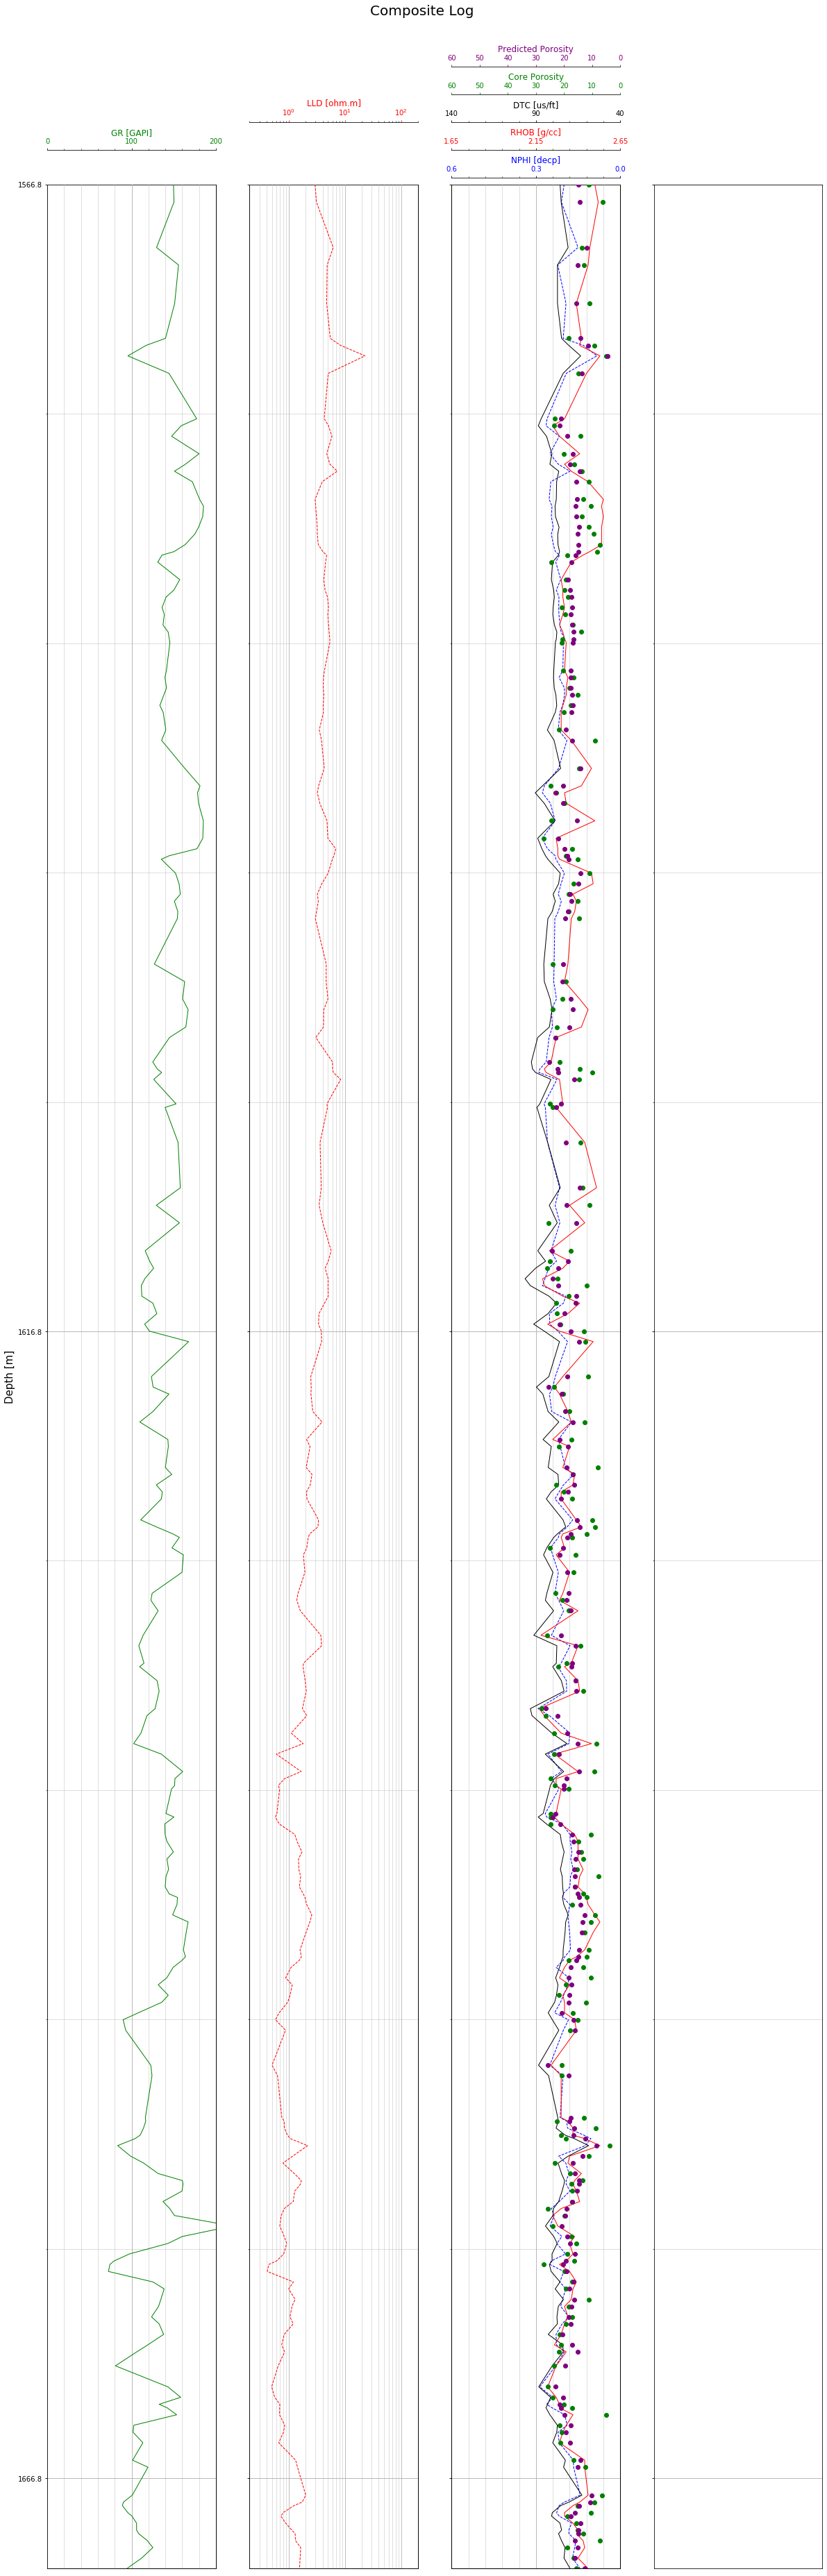

In [303]:
def plot_rcal(df,y_pred,depth_pred):
    '''
    Plot facies identified by geologist compared with clustering results
    '''
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,60),sharey=True)
    fig.suptitle("Composite Log", fontsize=20)
    fig.subplots_adjust(top=0.92)

    top = df['DEPTH'].min()
    bottom = df['DEPTH'].max()
    
    for axes in ax:
        axes.set_ylim(bottom,top)
        depth_major_ticks = np.arange(top, bottom, 50)
        depth_minor_ticks = np.arange(top, bottom, 10)
        axes.set_yticks(depth_major_ticks)
        axes.set_yticks(depth_minor_ticks, minor=True)
        axes.get_xaxis().set_visible(False) 
        axes.grid(which='minor', axis='y', alpha=0.5)
        axes.grid(which='major', axis='y', alpha=1)


    ax[0].set_ylabel("Depth [m]",color="Black",fontsize=15)

    #Track 1: GR and CALI
    #GR
    ax_GR=ax[0].twiny()
    ax_GR.set_xlim(0,200)
    ax_GR.set_xlabel('GR [GAPI]',color="Green",fontsize=12)
    ax_GR.plot(df['GR'],df['DEPTH'],color="Green",label='GR [GAPI]',linewidth=1)
    ax_GR.tick_params(axis='x', colors='Green')
    ax_GR.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(0, 201, 100)
    minor_ticks = np.arange(0, 201, 20)
    ax_GR.set_xticks(major_ticks)
    ax_GR.set_xticks(minor_ticks, minor=True)
    ax_GR.grid(which='minor', alpha=0.5)
    ax_GR.grid(which='major', alpha=1)


    #Track 2: Resistivity
    #LLD
    ax_LLD=ax[1].twiny()
    ax_LLD.set_xscale('log')
    ax_LLD.set_xlim(0.2,200)
    ax_LLD.set_xlabel('LLD [ohm.m]',color="Red",fontsize=12)
    ax_LLD.plot(df['LLD'],df['DEPTH'],'--',color="Red",label='LLD [ohm.m]',linewidth=1)
    ax_LLD.tick_params(axis='x', colors='Red')
    ax_LLD.spines['top'].set_position(('outward',90))
    ax_LLD.grid(which='minor', alpha=0.5)
    ax_LLD.grid(which='major', alpha=1)

#     #MSFL
#     ax_MSFL=ax[1].twiny()
#     ax_MSFL.set_xscale('log')
#     ax_MSFL.set_xlim(0.2,200)
#     ax_MSFL.set_xlabel('MSFL [ohm.m]',color="Black",fontsize=12)
#     ax_MSFL.plot(df['MSFL'],df['DEPTH'],color="Black",label='MSFL [ohm.m]',linewidth=1)
#     ax_MSFL.spines['top'].set_position(('outward',10))

    
    #Track 3: NPHI, RHOB, DTC, PET
    #NPHI
    ax_NEU=ax[2].twiny()
    ax_NEU.set_xlim(0.6,0)
    ax_NEU.set_xlabel('NPHI [decp]',color="Blue",fontsize=12)
    ax_NEU.plot(df['NPHI'],df['DEPTH'],'--',color="Blue",label='NPHI [decp]',linewidth=1)
    ax_NEU.tick_params(axis='x', colors='Blue')
    ax_NEU.spines['top'].set_position(('outward',10))
    major_ticks = np.arange(0, 0.61, 0.3)
    minor_ticks = np.arange(0, 0.61, 0.06)
    ax_NEU.set_xticks(major_ticks)
    ax_NEU.set_xticks(minor_ticks, minor=True)
    ax_NEU.grid(which='minor', alpha=0.5)
    ax_NEU.grid(which='major', alpha=1)

    #RHOB
    ax_RHOB=ax[2].twiny()
    ax_RHOB.set_xlim(1.65,2.65)
    ax_RHOB.set_xlabel('RHOB [g/cc]',color="Red",fontsize=12)
    ax_RHOB.plot(df['RHOB'],df['DEPTH'],color="Red",label='RHOB [g/cc]',linewidth=1)
    ax_RHOB.tick_params(axis='x', colors='Red')
    ax_RHOB.spines['top'].set_position(('outward',50))
    major_ticks = np.arange(1.65, 2.66, 0.5)
    minor_ticks = np.arange(1.65, 2.66, 0.1)
    ax_RHOB.set_xticks(major_ticks)
    ax_RHOB.set_xticks(minor_ticks, minor=True)

    #DTC
    ax_DTC=ax[2].twiny()
    ax_DTC.set_xlim(140,40)
    ax_DTC.set_xlabel('DTC [us/ft]',color="Black",fontsize=12)
    ax_DTC.plot(df['DTC'],df['DEPTH'],color="Black",label='DTC [us/ft]',linewidth=1)
    ax_DTC.spines['top'].set_position(('outward',90))
    major_ticks = np.arange(40, 141, 50)
    minor_ticks = np.arange(40, 141, 10)
    ax_DTC.set_xticks(major_ticks)
    ax_DTC.set_xticks(minor_ticks, minor=True)

    #core porosity
    ax_por=ax[2].twiny()
    ax_por.set_xlim(60,0)
    ax_por.set_xlabel('Core Porosity',color="Green",fontsize=12)
    ax_por.scatter(df['HE POR'],df['DEPTH'],color="Green",label='Core Porosity',linewidth=1)
    ax_por.tick_params(axis='x', colors='Green')
    ax_por.spines['top'].set_position(('outward',130))

    #prediction results
    ax_pred=ax[2].twiny()
    ax_pred.set_xlim(60,0)
    ax_pred.set_xlabel('Predicted Porosity',color="Purple",fontsize=12)
    ax_pred.scatter(y_pred[:,0],depth_pred,color="Purple",label='Predicted Porosity',linewidth=1)
    ax_pred.tick_params(axis='x', colors='Purple')
    ax_pred.spines['top'].set_position(('outward',170))

#     #KH
#     ax_kh=ax[3].twiny()
#     ax_kh.set_xscale('log')
#     ax_kh.set_xlim(0.01,10000)
#     ax_kh.set_xlabel('Kh',color="Green",fontsize=12)
#     ax_kh.scatter(df['KH'],df['DEPTH'],color="Green",label='Kh',linewidth=1)
#     ax_kh.tick_params(axis='x', colors='Green')
#     ax_kh.spines['top'].set_position(('outward',10))

#     #KH predicted
#     ax_kh_pred=ax[3].twiny()
#     ax_kh_pred.set_xscale('log')
#     ax_kh_pred.set_xlim(0.01,10000)
#     ax_kh_pred.set_xlabel('Kh Predicted',color="Purple",fontsize=12)
#     ax_kh_pred.scatter(y_pred[:,1],depth_pred,color="Purple",label='Kh Predicted',linewidth=1)
#     ax_kh_pred.tick_params(axis='x', colors='Purple')
#     ax_kh_pred.spines['top'].set_position(('outward',50))

plot_rcal(las_df_well_1_TC_core,y_pred,las_df_well_1_TC_core['DEPTH'])

<h1> Part 3 </h1>
<h2> Predict Porosity and Permeability of other wells in the same field </h2>

In [185]:
#load LAS data

las_df_well_2 = load_LAS("./data/well_2.las")
las_df_well_2

Header section Parameter regexp=~P was not found.


,CALI,DRHO,DTC,GR,LLD,LLS,MSFL,NPHI,RHOB,SP,AZIM,EASTING,INC,NORTHING,TVD,DEPTH
DEPTH,,,,,,,,,,,,,,,,
798.6139,NaN,NaN,174.4710,109.049,2.4615,1.5533,140.492,NaN,2.0012,-327.163,125.2955,401253.4375,43.0868,85595.0938,736.4166,798.6139
798.7663,NaN,NaN,172.9800,107.666,2.4923,1.5761,136.075,NaN,2.0055,-326.795,125.2947,401253.5625,43.0877,85595.0078,736.5627,798.7663
798.9187,NaN,NaN,171.5640,107.890,2.5163,1.5896,136.409,NaN,2.0096,-326.736,125.2944,401253.6250,43.0882,85594.9688,736.6357,798.9187
799.0711,NaN,NaN,169.0380,112.576,2.5545,1.6051,111.354,NaN,2.0171,-326.973,125.2936,401253.7188,43.0891,85594.8906,736.7818,799.0711
799.2235,NaN,NaN,168.3960,115.341,2.5597,1.6026,115.442,NaN,2.0190,-327.003,125.2933,401253.7813,43.0896,85594.8516,736.8549,799.2235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087.0035,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401799.9063,24.6800,85082.6406,1775.0187,2087.0035
2087.1559,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401799.9688,24.6800,85082.5781,1775.2004,2087.1559
2087.3083,NaN,NaN,80.5212,NaN,NaN,NaN,NaN,NaN,2.6208,NaN,135.2137,401800.0000,24.6800,85082.5469,1775.2913,2087.3083


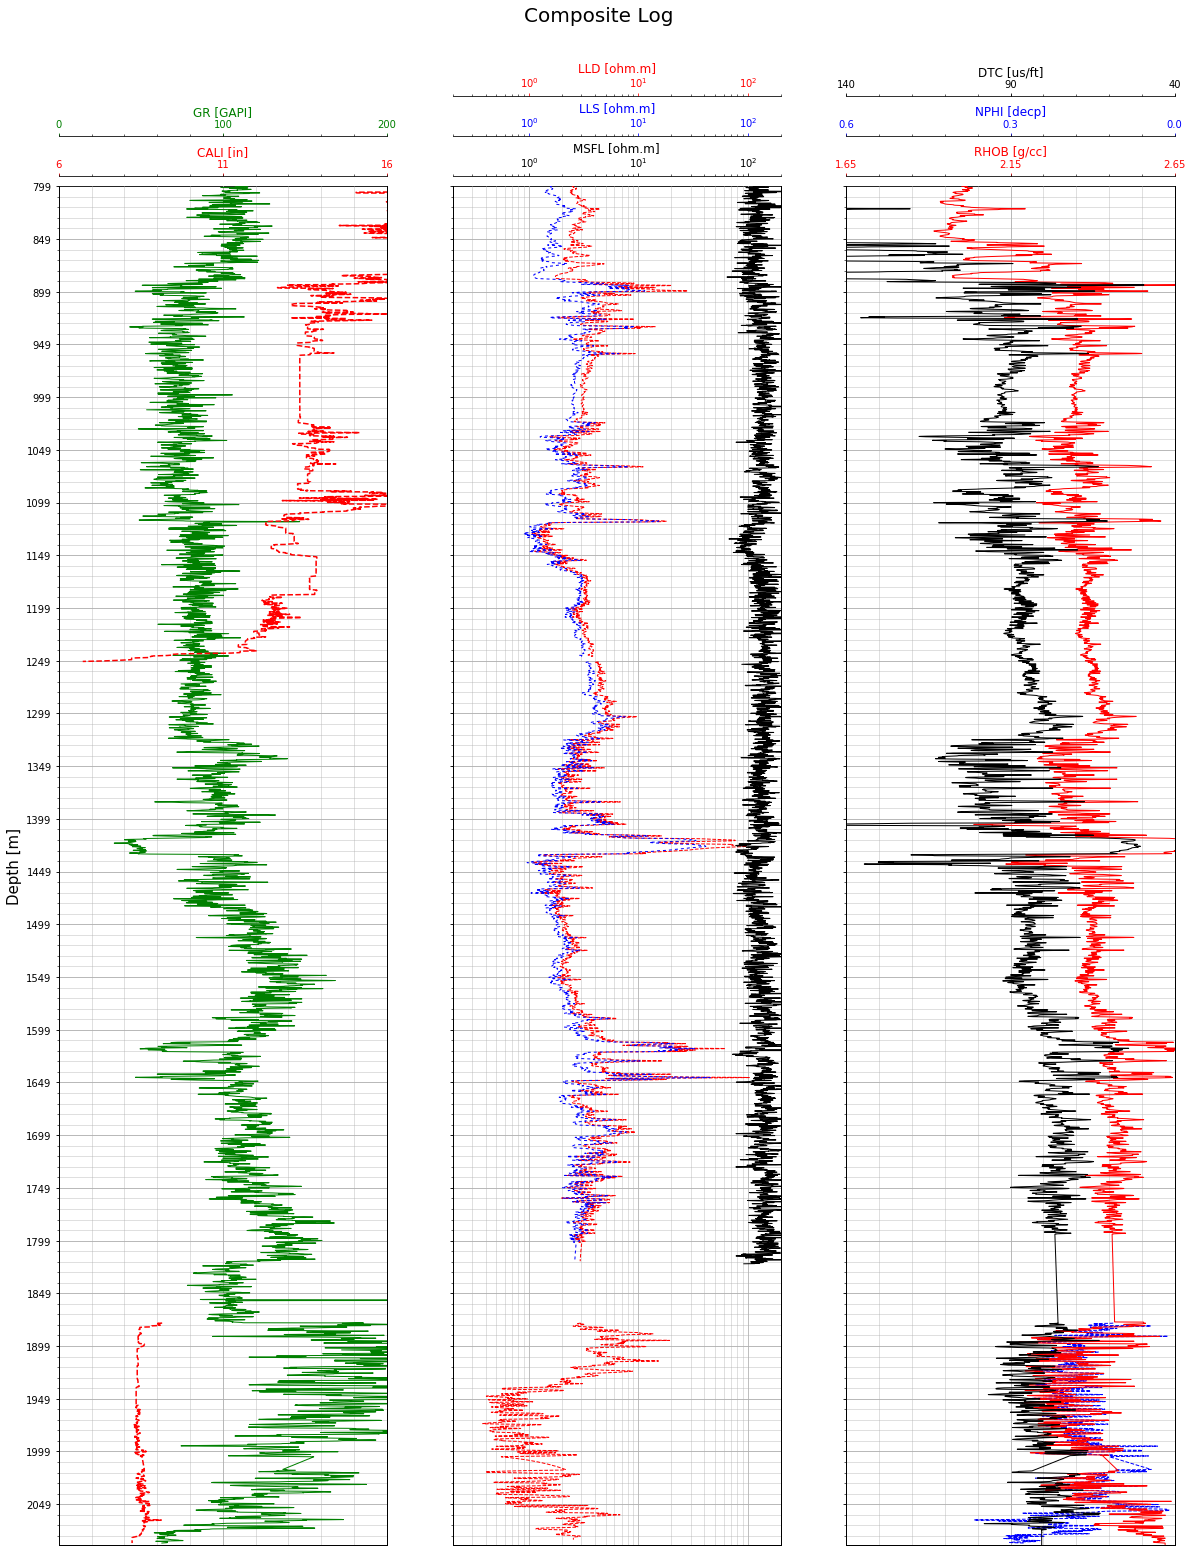

In [190]:
top = las_df_well_2['DEPTH'].min()
bottom = las_df_well_2['DEPTH'].max()

wireline_log_plotting(top,bottom,las_df_well_2)

From the plot we can see that: <br>
no MSFL and LLS curve after around 1820 mMD (which is suspected to be reservoir zone) <br>
no NPHI in the upper zone

In [192]:
las_df_well_2_TC = las_df_well_2_TC[['DEPTH','GR','NPHI','RHOB','DTC','LLD']]
las_df_well_2_TC.index = pd.RangeIndex(len(las_df_well_2_TC.index))

las_df_well_2_TC.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD
0,798.6139,109.049,NaN,2.0012,174.471,2.4615
1,798.7663,107.666,NaN,2.0055,172.980,2.4923
2,798.9187,107.890,NaN,2.0096,171.564,2.5163
3,799.0711,112.576,NaN,2.0171,169.038,2.5545
4,799.2235,115.341,NaN,2.0190,168.396,2.5597


In [194]:
#load RCAL data

df_rcal_well_2 = pd.read_csv('./data/well_2_rcal.csv')
df_rcal_well_2

,DEPTH (m),HE POR,KH,KV,Shift,1.1,Unnamed: 6
0,1885.02,13.8,1.40,20.00,1886.12,NaN,NaN
1,1885.25,14.4,5.90,NaN,1886.35,NaN,NaN
2,1885.50,9.3,0.14,NaN,1886.60,NaN,NaN
3,1885.76,12.5,0.18,NaN,1886.86,NaN,NaN
4,1886.02,12.4,0.37,0.03,1887.12,NaN,NaN
...,...,...,...,...,...,...,...
3966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3969,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
#create dataframe for scaled data
df_scaled_well_2 = scaling_features(las_df_well_2_TC)
df_scaled_well_2.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,0.210526,NaN,0.102477,0.791153,0.020336,NaN,NaN
1,798.7663,0.206656,NaN,0.107674,0.781723,0.020637,NaN,NaN
2,798.9187,0.207283,NaN,0.112628,0.772769,0.020871,NaN,NaN
3,799.0711,0.220397,NaN,0.121692,0.756794,0.021244,NaN,NaN
4,799.2235,0.228135,NaN,0.123988,0.752734,0.021294,NaN,NaN


In [204]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC,
                                            df_rcal_well_2,
                                            col_name='KH',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,109.049,NaN,2.0012,174.471,2.4615,NaN,NaN
1,798.7663,107.666,NaN,2.0055,172.980,2.4923,NaN,NaN
2,798.9187,107.890,NaN,2.0096,171.564,2.5163,NaN,NaN
3,799.0711,112.576,NaN,2.0171,169.038,2.5545,NaN,NaN
4,799.2235,115.341,NaN,2.0190,168.396,2.5597,NaN,NaN


In [205]:
# Add core data to the dataframe
las_df_well_2_TC_core = shift_core_depth(
                                            las_df_well_2_TC_core,
                                            df_rcal_well_2,
                                            col_name='HE POR',
                                            depth_rcal='Shift',
                                            depth='DEPTH'
                                        )
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,798.6139,109.049,NaN,2.0012,174.471,2.4615,NaN,NaN
1,798.7663,107.666,NaN,2.0055,172.980,2.4923,NaN,NaN
2,798.9187,107.890,NaN,2.0096,171.564,2.5163,NaN,NaN
3,799.0711,112.576,NaN,2.0171,169.038,2.5545,NaN,NaN
4,799.2235,115.341,NaN,2.0190,168.396,2.5597,NaN,NaN


We will select the lower part of the log which is supposed to be the reservoir zone

In [206]:
las_df_well_2_TC_core = las_df_well_2_TC_core.loc[las_df_well_2_TC_core['DEPTH']>1880].dropna()
las_df_well_2_TC_core.index = pd.RangeIndex(len(las_df_well_2_TC_core.index))
las_df_well_2_TC_core.head()

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,1886.1403,177.375,0.1580,2.4193,75.8117,10.2281,1.40,13.8
1,1886.4451,162.800,0.1539,2.4679,79.0125,10.4848,5.90,14.4
2,1886.9023,167.644,0.1606,2.5263,79.0704,12.5748,0.18,12.5
3,1887.2071,166.093,0.1480,2.5153,77.5949,13.5280,0.37,12.4
4,1887.3595,155.248,0.1067,2.5177,77.6811,12.1009,49.00,11.5


In [207]:
#save the dataframe
las_df_well_2_TC_core.to_csv('las_df_well_2_TC_core.csv')

Use the trained model to predict KH and HE POR <br>
We will compare with data from RCAL

In [356]:
test_X_df_2 = las_df_well_2_TC_core.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

,GR,NPHI,RHOB,DTC,LLD
0,177.375,0.1580,2.4193,75.8117,10.2281
1,162.800,0.1539,2.4679,79.0125,10.4848
2,167.644,0.1606,2.5263,79.0704,12.5748
3,166.093,0.1480,2.5153,77.5949,13.5280
4,155.248,0.1067,2.5177,77.6811,12.1009
...,...,...,...,...,...
151,185.863,0.1739,2.3257,85.8084,0.6958
152,168.891,0.1651,2.3066,74.6443,0.9145
153,167.699,0.2224,2.2167,89.1595,0.4355
154,211.222,0.2050,2.2800,85.7968,0.5714


In [344]:
scaler = MinMaxScaler()
df_temp = las_df_well_2_TC_core
df_scaled_well_2 = pd.DataFrame(scaler.fit_transform(las_df_well_2_TC_core), columns=las_df_well_2_TC_core.columns)
df_scaled_well_2['DEPTH'] = df_temp['DEPTH']
df_scaled_well_2['HE POR'] = df_temp['HE POR']
df_scaled_well_2['KH'] = df_temp['KH']
df_scaled_well_2

,DEPTH,GR,NPHI,RHOB,DTC,LLD,KH,HE POR
0,1886.1403,0.407028,0.556996,0.613057,0.347405,0.538946,1.40,13.8
1,1886.4451,0.310425,0.538668,0.742038,0.446950,0.553032,5.90,14.4
2,1886.9023,0.342531,0.568619,0.897028,0.448750,0.667724,0.18,12.5
3,1887.2071,0.332251,0.512293,0.867834,0.402862,0.720032,0.37,12.4
4,1887.3595,0.260370,0.327671,0.874204,0.405543,0.641718,49.00,11.5
...,...,...,...,...,...,...,...,...
151,1950.9103,0.463287,0.628073,0.364650,0.658302,0.015848,153.00,18.2
152,1951.6723,0.350796,0.588735,0.313960,0.311099,0.027850,1.20,16.6
153,1952.1295,0.342895,0.844882,0.075372,0.762521,0.001564,1.40,13.4
154,1953.1963,0.631368,0.767099,0.243365,0.657941,0.009022,116.00,18.2


In [345]:
test_X_df_2 = df_scaled_well_2.drop(['DEPTH','HE POR','KH'],axis=1)
test_X_df_2

,GR,NPHI,RHOB,DTC,LLD
0,0.407028,0.556996,0.613057,0.347405,0.538946
1,0.310425,0.538668,0.742038,0.446950,0.553032
2,0.342531,0.568619,0.897028,0.448750,0.667724
3,0.332251,0.512293,0.867834,0.402862,0.720032
4,0.260370,0.327671,0.874204,0.405543,0.641718
...,...,...,...,...,...
151,0.463287,0.628073,0.364650,0.658302,0.015848
152,0.350796,0.588735,0.313960,0.311099,0.027850
153,0.342895,0.844882,0.075372,0.762521,0.001564
154,0.631368,0.767099,0.243365,0.657941,0.009022


In [357]:
# test_y_df_2 = las_df_well_2_TC_core[['HE POR','KH']]
test_y_df_2 = las_df_well_2_TC_core[['HE POR']]

In [346]:
test_y_df_2 = df_scaled_well_2[['HE POR']]
test_y_df_2

,HE POR
0,13.8
1,14.4
2,12.5
3,12.4
4,11.5
...,...
151,18.2
152,16.6
153,13.4
154,18.2


In [358]:
y_pred_well_2 = model.predict(test_X_df_2.to_numpy())

In [359]:
model.evaluate(test_X_df_2.to_numpy(),test_y_df_2.to_numpy())

156/156 [==============================] - 0s 51us/sample - loss: 45.4711


45.47114073924529

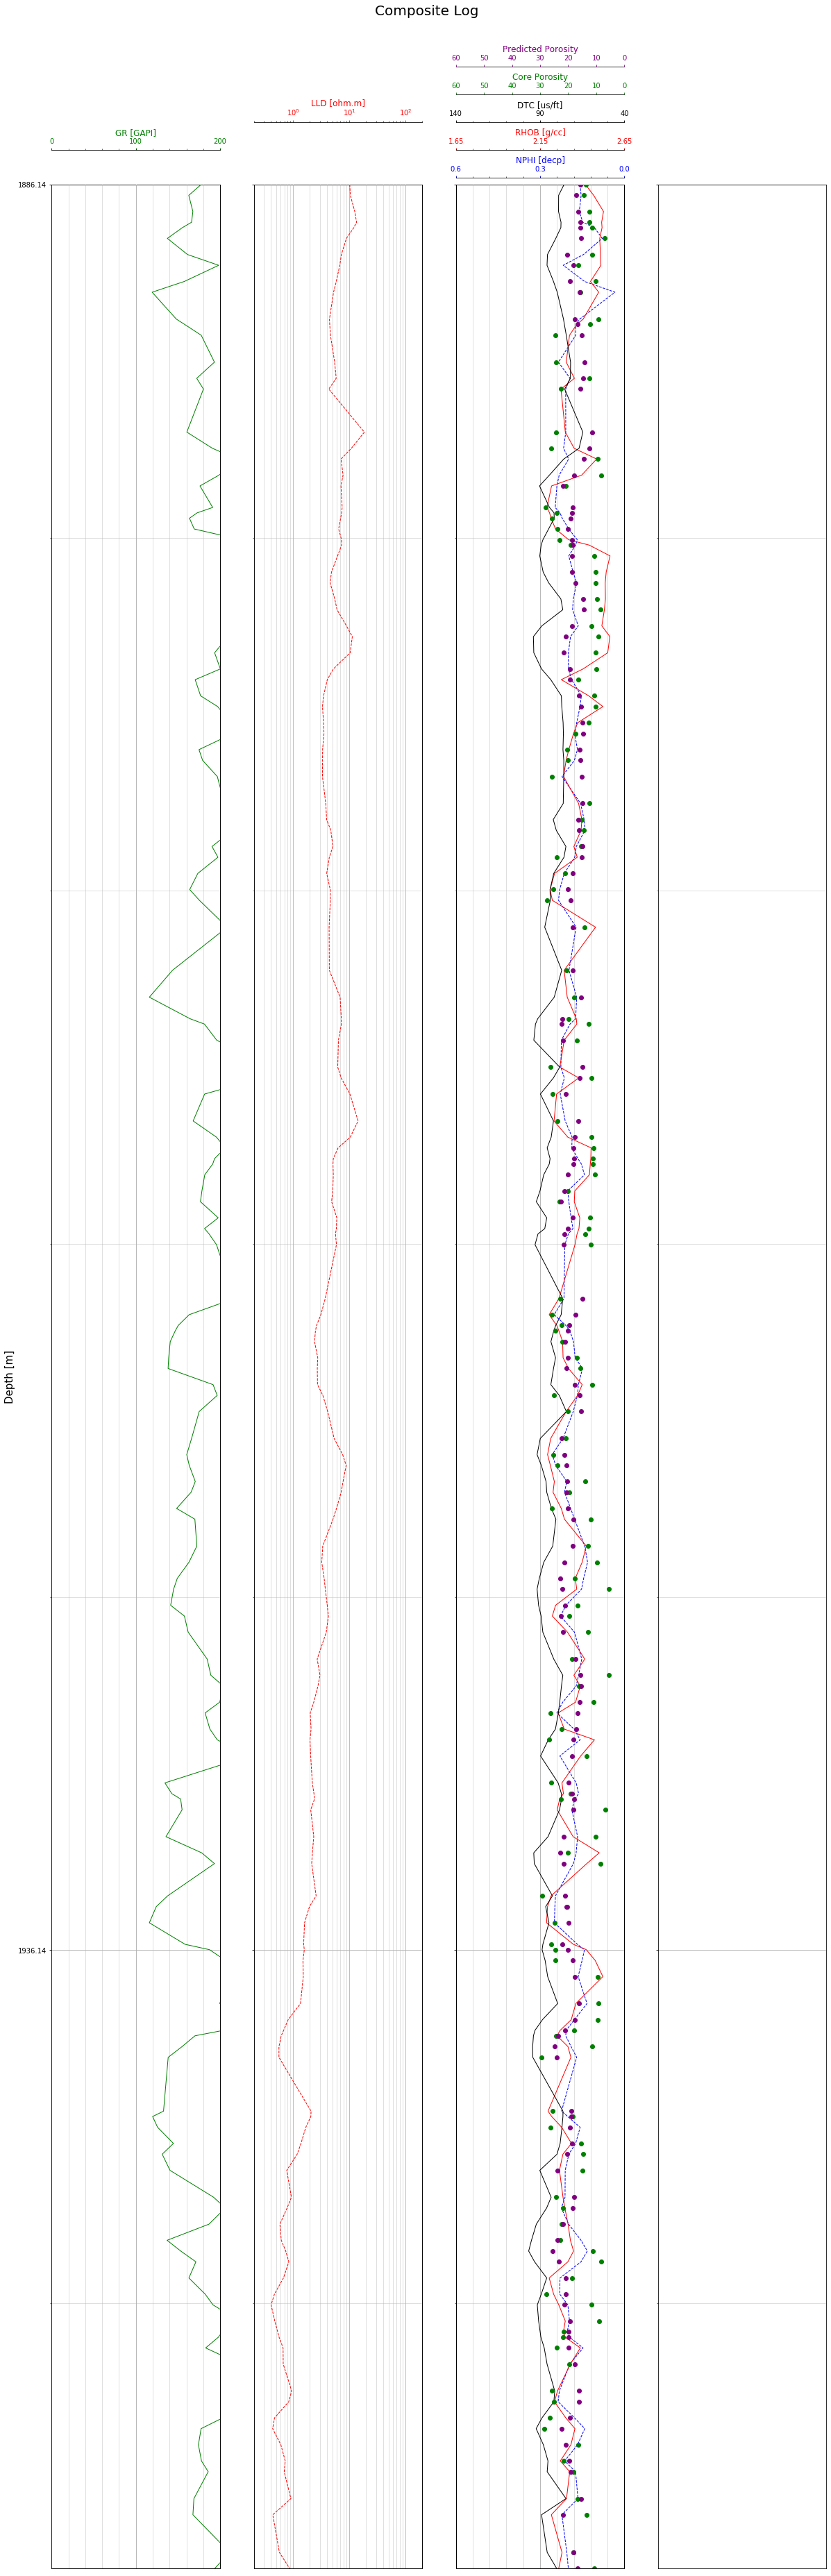

In [360]:
plot_rcal(las_df_well_2_TC_core,y_pred_well_2,las_df_well_2_TC_core['DEPTH'])